# Compare speed of casADi for multiple points interpolation vs. JAX libraries

In [16]:
from dataclasses import dataclass
import casadi as ca
import numpy as np
import time
import math
from typing import Dict, Optional
import logging
import datetime
import timeit
from tqdm import tqdm

from ocean_navigation_simulator.data_sources import OceanCurrentSource
from ocean_navigation_simulator.data_sources.SolarIrradiance.SolarIrradianceSource import SolarIrradianceSource
from ocean_navigation_simulator.data_sources.SeaweedGrowth.SeaweedGrowthSource import SeaweedGrowthSource
from ocean_navigation_simulator.utils import units
from ocean_navigation_simulator.environment.PlatformState import PlatformState
from ocean_navigation_simulator.environment.PlatformState import SpatialPoint
from ocean_navigation_simulator.environment.ArenaFactory import ArenaFactory
from ocean_navigation_simulator.environment.NavigationProblem import NavigationProblem
from ocean_navigation_simulator.controllers.hj_planners.HJReach2DPlanner import HJReach2DPlanner
from ocean_navigation_simulator.utils import units
import matplotlib.pyplot as plt
import os
#os.chdir('/home/nicolas/documents/Master_Thesis_repo/OceanPlatformControl')
os.chdir('/home/nicolas/codeRepo/OceanPlatformControl')
print(os.getcwd())

/home/nicolas/codeRepo/OceanPlatformControl


+ Import the ocean source

In [17]:
from ocean_navigation_simulator.data_sources.OceanCurrentField import OceanCurrentField
from ocean_navigation_simulator.data_sources.SeaweedGrowthField import SeaweedGrowthField
from ocean_navigation_simulator.data_sources.SolarIrradianceField import SolarIrradianceField
from typing import Dict, Optional, Union, Tuple, List, AnyStr, Literal, Callable
import yaml

scenario_name = 'gulf_of_mexico_HYCOM_hindcast_local'
with open(f'config/arena/{scenario_name}.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
casadi_cache_dict=config['casadi_cache_dict']
platform_dict=config['platform_dict']
ocean_dict= config['ocean_dict']
use_geographic_coordinate_system=config['use_geographic_coordinate_system']
spatial_boundary=config['spatial_boundary']

ocean_field = OceanCurrentField(
    casadi_cache_dict=casadi_cache_dict,
    hindcast_source_dict=ocean_dict['hindcast'],
    forecast_source_dict=ocean_dict['forecast'],
    use_geographic_coordinate_system=use_geographic_coordinate_system)

ocean_source = ocean_field.hindcast_data_source

INFO:arena.ocean_field:DataField: Create Hindcast Source (3.3s)
INFO:arena.ocean_field:DataField: Forecast is the same as Hindcast for OceanCurrents.


+ Create the typical implementation of a `PlatformStateSet` class, containing a list of `PlatformState`: redefine np.array methods to extract states 

In [18]:
from typing import List
import dataclasses
from dataclasses import astuple
@dataclasses.dataclass
class PlatformStateSet:
    states:List[PlatformState]

    def __array__(self):
        return np.array(self.states) #rows are the number of platforms

    def __len__(self):
        return len(self.states)

    def __getitem__(self, platform_id):
    #     return np.array(self.states[platform_id])
        return self.states[platform_id]

    def __post_init__(self):
        self.lon_arr = np.array(self.states)[:,0]
        self.lat_arr = np.array(self.states)[:,1]
        self.date_time_arr = np.array(self.states)[:,2]
        self.battery_charge = np.array(self.states)[:,3]
        self.seaweed_mass = np.array(self.states)[:,4]

+ Create functions to generate random platform states

In [19]:
def rand_platforms(nb_platforms):
    lon = np.random.uniform(low=-83.5, high=-83, size=(nb_platforms,))
    lat = np.random.uniform(low=23, high=23.5, size=(nb_platforms,))
    id = np.arange(start=1, stop=nb_platforms+1, step=1)
    t = np.repeat(datetime.datetime(2021, 11, 24, 12, 0, tzinfo=datetime.timezone.utc), nb_platforms)
    return lon,lat,id,t
    
def get_platform(nb_platforms):
    lon,lat,id,t = rand_platforms(nb_platforms)
    platforms_list = [PlatformState(lon=units.Distance(deg=lon[k]), lat=units.Distance(deg=lat[k]), date_time=t[k]) \
                      for k in range(nb_platforms)]
    # create the Set class for the platforms (version 1 with list of Platform states)
    platforms_set = PlatformStateSet(states=platforms_list)
    return platforms_set

**Rewrite** `convert_to_x_y_time_bounds` to support multiple platform states, making use of the methods implemented in PlatformStateSet

In [20]:
def convert_to_x_y_time_bounds(
    states: PlatformStateSet,
    x_T: SpatialPoint,
    deg_around_x0_xT_box: float,
    temp_horizon_in_s: float,
):
    """Helper function for spatio-temporal subsetting
    Args:
        x_0: SpatioTemporalPoint
        x_T: SpatialPoint goal locations
        deg_around_x0_xT_box: buffer around the box in degree
        temp_horizon_in_s: maximum temp_horizon to look ahead of x_0 time in seconds

    Returns:
        t_interval: if time-varying: [t_0, t_T] as utc datetime objects
                    where t_0 and t_T are the start and end respectively
        lat_bnds: [y_lower, y_upper] in degrees
        lon_bnds: [x_lower, x_upper] in degrees
    """

    t_interval = [datetime.datetime.fromtimestamp(min(states.date_time_arr), tz=datetime.timezone.utc), \
                  datetime.datetime.fromtimestamp(max(states.date_time_arr), tz=datetime.timezone.utc) + datetime.timedelta(seconds=temp_horizon_in_s)]
    lon_bnds = [
        min(min(states.lon_arr), x_T.lon.deg) - deg_around_x0_xT_box,
        max(max(states.lon_arr), x_T.lon.deg) + deg_around_x0_xT_box,
    ]
    lat_bnds = [
        min(min(states.lat_arr), x_T.lat.deg) - deg_around_x0_xT_box,
        max(max(states.lat_arr), x_T.lat.deg) + deg_around_x0_xT_box,
    ]

    return t_interval, lat_bnds, lon_bnds

## TIME EVALUATION

In [21]:
import timeit
import jax.numpy as jnp
import jax.scipy.ndimage
from jax import jit
from scipy import interpolate
from functools import partial

+ Create random platforms and define the grid to be interpolated on (or cached in casADi)

In [22]:
nb_platforms_span = [1, 50, 100, 250, 500, 750, 1000, 1250, 1500] # number of platforms to be evaluated
grid_list = []
xr_curr_list = []
platforms_set_list = []
for nb_platforms in nb_platforms_span: # loop across the nb of platforms to try out and save data
    platforms_set = get_platform(nb_platforms) # get random location for platforms
    platforms_set_list.append(platforms_set) 
    # Step 1: Create the intervals to query data for
    t_interval, y_interval, x_interval, = convert_to_x_y_time_bounds(
        states=platforms_set,
        x_T=platforms_set[0].to_spatial_point(),    
        deg_around_x0_xT_box=ocean_source.source_config_dict["casadi_cache_settings"]["deg_around_x_t"],
        temp_horizon_in_s=ocean_source.source_config_dict["casadi_cache_settings"]["time_around_x_t"],
    )
    #print(t_interval, x_interval, y_interval)
    # Step 2: Get the data from itocean_source and update casadi_grid_dict
    xarray = ocean_source.get_data_over_area(x_interval, y_interval, t_interval)
    xr_curr_list.append(xarray)
    ocean_source.casadi_grid_dict = ocean_source.get_grid_dict_from_xr(xarray)
    # Step 3: Set up the grid with time lat lon order as for the xarray dataset
    grid_list.append([
        units.get_posix_time_from_np64(xarray.coords["time"].values),  
        xarray.coords["lat"].values,
        xarray.coords["lon"].values,
    ])

### CasADi Interpolation

In [23]:
t_avg_cas = []
for idx in range(len(nb_platforms_span)):
    ocean_source.initialize_casadi_functions(grid_list[idx], xr_curr_list[idx])
    platforms_set = platforms_set_list[idx] # get the corresponding states for the nb of platforms to test 
    lon_lat_t = np.array(platforms_set)[:,[2,1,0]].T # extract time, lat, lon with platforms as columns for casADi interpolation
    u_curr_cas = %timeit -n 1000 -r 10 -o ocean_source.u_curr_func(lon_lat_t)
    v_curr_cas = %timeit -n 1000 -r 10 -o ocean_source.v_curr_func(lon_lat_t)
    t_avg_cas.append((u_curr_cas.average+v_curr_cas.average)*1e6) # in us

14.3 µs ± 1.15 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)
13.8 µs ± 214 ns per loop (mean ± std. dev. of 10 runs, 1,000 loops each)
41.2 µs ± 674 ns per loop (mean ± std. dev. of 10 runs, 1,000 loops each)
42.8 µs ± 3.7 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)
65.4 µs ± 881 ns per loop (mean ± std. dev. of 10 runs, 1,000 loops each)
65.9 µs ± 1.2 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)
140 µs ± 5.07 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)
141 µs ± 4.51 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)
258 µs ± 1.71 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)
262 µs ± 4.7 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)
382 µs ± 2.88 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)
383 µs ± 3.93 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)
505 µs ± 3.64 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)
506 µs ± 3.77 µs per loop (mean ± std.

### JAX Interpolation

+ Check if we run on gpu

In [24]:
jax.default_backend()
_gpu = jax.devices("gpu")[0]

+ Interpolation function with jax and scipy: first scale input relatively to the grid range (as indices) using `jnp.interp`

In [25]:
@jit
def init_lin_interpo_3D_fields(states_np, u_curr, v_curr, grid_eval):
    print("First time init for jit")
    idx_point = jnp.array(# time lat lon order as for the xarray dataset
    [
        jnp.interp(states_np[:,2], grid_eval[0], np.arange(len(grid_eval[0]))),
        jnp.interp(states_np[:,1], grid_eval[1], np.arange(len(grid_eval[1]))),
        jnp.interp(states_np[:,0], grid_eval[2], np.arange(len(grid_eval[2]))),
    ]
    )
    u_curr_interp = jax.scipy.ndimage.map_coordinates(u_curr, idx_point, order=1) 
    v_curr_interp = jax.scipy.ndimage.map_coordinates(v_curr, idx_point, order=1)
    return u_curr_interp, v_curr_interp

In [33]:
t_avg_jax_cpu_states = [] # list to measure avg running time when we run the platform states are kept on CPU
t_avg_jax_gpu_states = [] # list to measure avg running time when we run the platform states are on GPU
for idx in range(len(nb_platforms_span)):
    xarray = xr_curr_list[idx]
    grid = grid_list[idx]
    u_curr_gt = xarray.water_u.values
    v_curr_gt = xarray.water_v.values
    states = np.array(platforms_set).astype('float32')
    # send to GPU
    u_curr_gt_gpu = jax.device_put(u_curr_gt, _gpu) 
    v_curr_gt_gpu = jax.device_put(v_curr_gt, _gpu)
    grid_gpu = jax.device_put(grid, _gpu)
    states_gpu = jax.device_put(states, _gpu)
    get_current_interp_gpu = partial(init_lin_interpo_3D_fields, u_curr=u_curr_gt_gpu, v_curr = v_curr_gt_gpu, \
                            grid_eval = grid_gpu)
    # initialize first (JIT first time is not counted)
    u,v = get_current_interp_gpu(states)

    #time when the states are still on cpu
    t_jax_cpu_states = %timeit -n 1000 -r 10 -o get_current_interp_gpu(states)
    t_avg_jax_cpu_states.append(t_jax_cpu_states.average*1e6)

    #time when the platform states are also on gpu
    t_jax_gpu_states = %timeit -n 1000 -r 10 -o get_current_interp_gpu(states_gpu)
    t_avg_jax_gpu_states.append(t_jax_gpu_states.average*1e6)

352 µs ± 34.9 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)
254 µs ± 1.74 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)
437 µs ± 67 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)
277 µs ± 8.2 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)
395 µs ± 36.3 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)
274 µs ± 1.27 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)
377 µs ± 51.6 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)
319 µs ± 52.7 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)
400 µs ± 52.7 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)
360 µs ± 52.2 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)
366 µs ± 30.3 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)
272 µs ± 4.3 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)
357 µs ± 45.9 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)
280 µs ± 5.09 µs per loop (mean ± std. dev

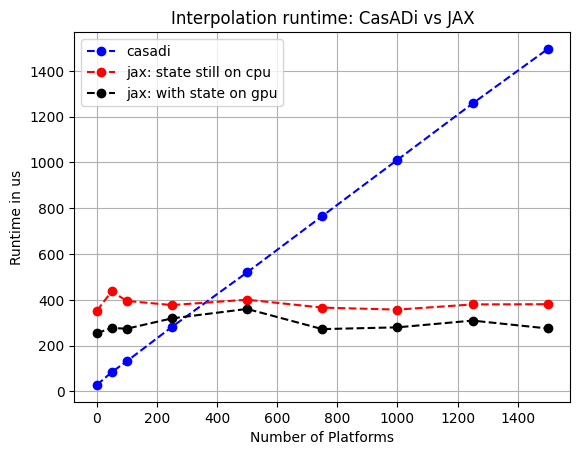

In [34]:
import matplotlib.pyplot as plt
plt.plot(nb_platforms_span, t_avg_cas, 'ob--', label = 'casadi')
plt.plot(nb_platforms_span, t_avg_jax_cpu_states, 'or--', label='jax: state still on cpu')
plt.plot(nb_platforms_span, t_avg_jax_gpu_states, 'ok--', label= 'jax: with state on gpu')
plt.xlabel("Number of Platforms")
plt.ylabel("Runtime in us")
plt.grid(visible=True)
plt.legend()
plt.title("Interpolation runtime: CasADi vs JAX")
plt.show()